# vLife Virtusa

## Drug Recommendation for Medical Practitioner Usecase
### Usecase Description
##### Help medical practitioners to prescribe recommended drugs based on their practicing specialty, years of practicing and previous suggested drugs in prescriptions by other providers or practitioners.Recommendation engine for Medical Practioner for recommeding suitable drugs based on their prescribing patterns.Solution is powerd by topic modelling algorithm LDA which recommends drugs based on practioner prescribing patterns

### Data Source
Data for this usecase can be found 
* [Source I](https://www.kaggle.com/tajuddinkh/drugs-prescriptions-with-providers)
* [Source II](https://www.kaggle.com/roamresearch/prescriptionbasedprediction)

### Dataset Description
##### You will find specialty is a doctor's or medical practitioners expertise and "years of practice" is the practice duration. each row is a provider's prescription where the drugs are suggested along with others relatively.
### Columns
* Index incremental
* specialtyMedical Practitioner's Expertise
* years_practicingYears of experiences to the expertise
* cms_prescription_countsprescribed medicines in association

#### Import Necessary Packages and Libraries

In [13]:
import numpy as np
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import seaborn as sns
import sklearn.metrics.base
import warnings
from collections import Counter
from pandas.io.json import json_normalize

from scipy.sparse import csr_matrix
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import (StratifiedKFold, GridSearchCV, train_test_split,
                                     cross_val_predict)


In [14]:
data = pd.read_csv('/kaggle/input/drugs-prescriptions-with-providers/medicine_prescription_records.csv',nrows=200).drop('Unnamed: 0',axis=1)
data.head()

,specialty,years_practicing,cms_prescription_counts
0,Nephrology,7,"DOXAZOSIN MESYLATE, MIDODRINE HCL, MEGESTROL A..."
1,General Practice,7,"CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAMINO..."
2,General Practice,7,"CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL"
3,General Practice,7,AMOXICILLIN
4,Nephrology,6,"PIOGLITAZONE HCL, BENAZEPRIL HCL, DIAZEPAM, HY..."


## Data Wrangling
### Exploratory Data Analysis

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
specialty                  200 non-null object
years_practicing           200 non-null int64
cms_prescription_counts    200 non-null object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [16]:
print("Dataset contains {} rows and {} columns".format(data.shape[0], data.shape[1]))

Dataset contains 200 rows and 3 columns


In [17]:
data[data['specialty'] == 'Nephrology']

,specialty,years_practicing,cms_prescription_counts
0,Nephrology,7,"DOXAZOSIN MESYLATE, MIDODRINE HCL, MEGESTROL A..."
4,Nephrology,6,"PIOGLITAZONE HCL, BENAZEPRIL HCL, DIAZEPAM, HY..."
35,Nephrology,6,"CALCIUM ACETATE, NEXIUM, HYDRALAZINE HCL, SENS..."
45,Nephrology,7,"MIDODRINE HCL, BENAZEPRIL HCL, GABAPENTIN, MET..."
46,Nephrology,8,"CALCIUM ACETATE, AMLODIPINE BESYLATE, HYDRALAZ..."


In [18]:
data.groupby("specialty")["years_practicing"].mean().sort_values(ascending=False)

specialty
Sports Medicine                         8.000000
Foot and Ankle Surgery                  8.000000
Pain Medicine                           8.000000
Cardiovascular Disease                  7.500000
Pulmonary Disease                       7.250000
Gastroenterology                        7.200000
Women's Health                          7.000000
Oral and Maxillofacial Surgery          7.000000
Critical Care Medicine                  7.000000
Gynecology                              7.000000
Hematology                              7.000000
Medical Oncology                        7.000000
Neurology                               7.000000
Acute Care                              7.000000
Pediatric Cardiology                    7.000000
Plastic and Reconstructive Surgery      7.000000
Radiation Oncology                      7.000000
Psych/Mental Health, Adult              7.000000
Nephrology                              6.800000
Endocrinology, Diabetes & Metabolism    6.750000
Psychiatry

In [19]:
for column in data.columns.values:
    print(f" Unique values of {column} : {data[column].nunique()}")

 Unique values of specialty : 40
 Unique values of years_practicing : 8
 Unique values of cms_prescription_counts : 183


In [20]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))
missing_data(data)

,specialty,years_practicing,cms_prescription_counts
Total,0,0,0
Percent,0,0,0
Types,object,int64,object


In [21]:
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (data.shape[0] 
                                - missing_df['missing_count']) / data.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,specialty,0,100.0
1,years_practicing,0,100.0
2,cms_prescription_counts,0,100.0


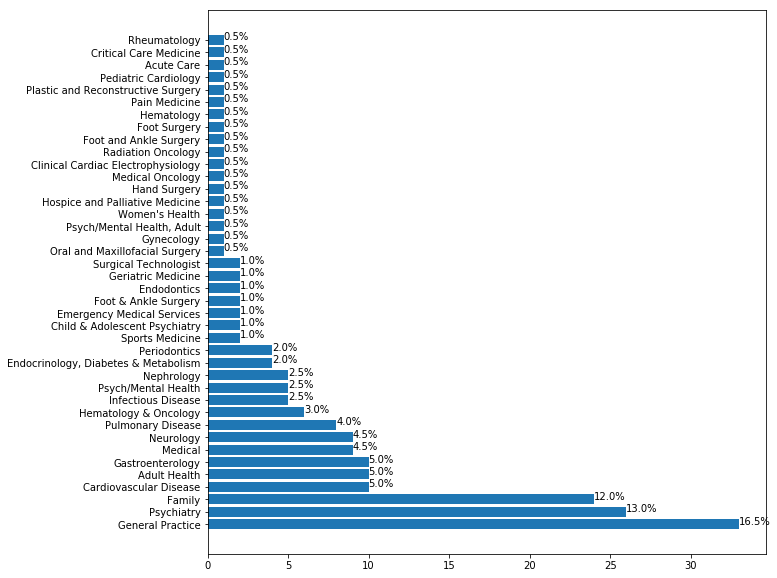

In [22]:
plt.figure(figsize=(10,10))
counts = pd.Series(data.specialty).value_counts()[:50] 
plt.barh(counts.index, counts.values)
for i, v in enumerate(counts.values):
    plt.text(v, i, '{:.1f}%'.format(100 * v / data.specialty.shape[0]))

In [23]:
F=data['specialty'].value_counts().sort_values(ascending=False)[:15]
label=F.index
size=F.values
colors = ['skyblue', '#FEBFB3', '#96D38C', '#D0F9B1', 'gold', 'orange', 'lightgrey', 
          'lightblue','lightgreen','aqua','yellow','#D4E157','#D1C4E9','#1A237E','#64B5F6','#009688',
          '#1DE9B6','#66BB6A','#689F38','#FFB300']
trace =go.Pie(labels=label, values=size, marker=dict(colors=colors), hole=.1)
data_trace = [trace]
layout = go.Layout(title='Distribution of specialty')
fig=go.Figure(data=data_trace,layout=layout)
py.iplot(fig)

Text(0.5, 1.0, 'Top20 : The number of Speciality in terms of prescrptions.')

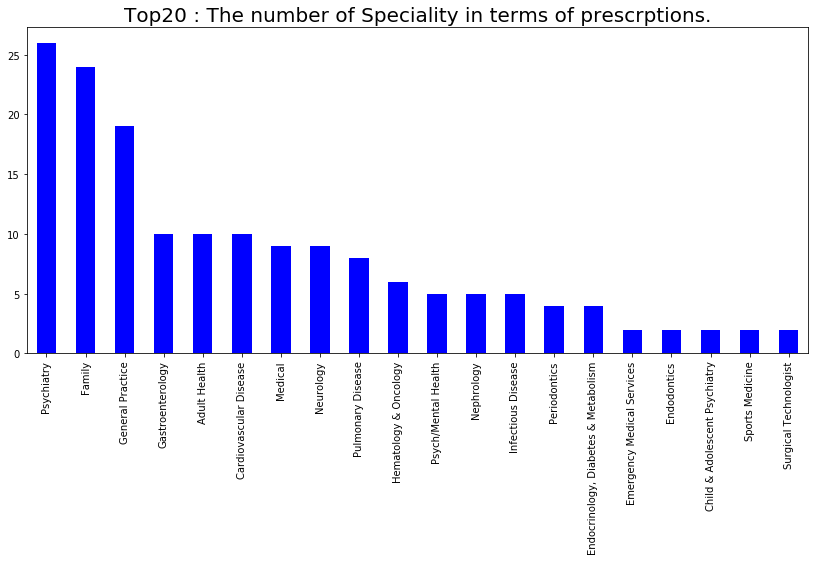

In [24]:
condition_dn = data.groupby(['specialty'])['cms_prescription_counts'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="blue")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of Speciality in terms of prescrptions.", fontsize = 20)

## Building Recommendation Engine 
*  Market Basket Analysis - FP Growth
*  Topic Modelling - LDA (Latent Dirichlet Allocation)

In [25]:
df = data.copy()
df = df.reset_index()
df = df[['index','cms_prescription_counts']]
display(df)

,index,cms_prescription_counts
0,0,"DOXAZOSIN MESYLATE, MIDODRINE HCL, MEGESTROL A..."
1,1,"CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAMINO..."
2,2,"CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL"
3,3,AMOXICILLIN
4,4,"PIOGLITAZONE HCL, BENAZEPRIL HCL, DIAZEPAM, HY..."
...,...,...
195,195,AMOXICILLIN
196,196,"SIMVASTATIN, INSULIN SYRINGE, FAMOTIDINE, KLOR..."
197,197,"SERTRALINE HCL, ESCITALOPRAM OXALATE, NAMENDA,..."
198,198,"SIMVASTATIN, XARELTO, HYDRALAZINE HCL, TOPROL ..."


### Data Preprocessing

In [26]:
def process(df):
    df.columns = ['trans', 'item']
#   df.trans = df.trans.sample(n=20000, random_state=1)
#   df.item = df.item.sample(n=20000, random_state=1)
#   df.trans = pd.to_numeric(df.trans, errors='coerce')
#   df.trans = df.trans.astype(int)
    df.item = df.item.apply(lambda x: str(x).split(','))
    df = df.groupby('trans').agg(lambda x: x)
    return df

df = process(df)
display(df)

,item
trans,
0,"[DOXAZOSIN MESYLATE, MIDODRINE HCL, MEGESTRO..."
1,"[CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAM..."
2,"[CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL]"
3,[AMOXICILLIN]
4,"[PIOGLITAZONE HCL, BENAZEPRIL HCL, DIAZEPAM,..."
...,...
195,[AMOXICILLIN]
196,"[SIMVASTATIN, INSULIN SYRINGE, FAMOTIDINE, ..."
197,"[SERTRALINE HCL, ESCITALOPRAM OXALATE, NAMEN..."


In [27]:
print(df['item'][0])

['DOXAZOSIN MESYLATE', ' MIDODRINE HCL', ' MEGESTROL ACETATE', ' BENAZEPRIL HCL', ' METOLAZONE', ' NOVOLOG', ' DIAZEPAM', ' HYDRALAZINE HCL', ' SENSIPAR', ' LABETALOL HCL', ' PREDNISONE', ' CALCITRIOL', ' HYDROCODONE-ACETAMINOPHEN', ' HYDROCHLOROTHIAZIDE', ' LOSARTAN-HYDROCHLOROTHIAZIDE', ' FENOFIBRATE', ' MINOXIDIL', ' MELOXICAM', ' ATENOLOL', ' CARISOPRODOL', ' GABAPENTIN', ' OMEPRAZOLE', ' KLOR-CON M10', ' LANTUS', ' AMLODIPINE BESYLATE', ' CARVEDILOL', ' LOSARTAN POTASSIUM', ' IRBESARTAN', ' NIFEDICAL XL', ' NIFEDIPINE ER', ' LEVOTHYROXINE SODIUM', ' POTASSIUM CHLORIDE', ' FUROSEMIDE', ' GLYBURIDE', ' CLONIDINE HCL', ' TEMAZEPAM', ' SPIRONOLACTONE', ' LOVASTATIN', ' LISINOPRIL', ' PANTOPRAZOLE SODIUM', ' CALCIUM ACETATE', ' NEXIUM', ' ZOLPIDEM TARTRATE', ' DIOVAN', ' OXYCODONE HCL', ' METOPROLOL SUCCINATE', ' RANITIDINE HCL', ' ATORVASTATIN CALCIUM', ' TAMSULOSIN HCL', ' OXYBUTYNIN CHLORIDE', ' LISINOPRIL-HYDROCHLOROTHIAZIDE', ' METOPROLOL TARTRATE', ' AMLODIPINE BESYLATE-BENAZEPRI

### FP Growth Algorithm

* Variables:
 - name of the node, a count
 - nodelink used to link similar items
 - parent vaiable used to refer to the parent of the node in the tree
 - node contains an empty dictionary for the children in the node

In [33]:
class treeNode:
    def __init__(self, nameValue, numOccur, parentNode):
        self.name = nameValue
        self.count = numOccur
        self.nodeLink = None
        self.parent = parentNode      #needs to be updated
        self.children = {} 
#increments the count variable with a given amount    
    def inc(self, numOccur):
        self.count += numOccur
#display tree in text. Useful for debugging        
    def disp(self, ind=1):
        print ('  '*ind, self.name, ' ', self.count)
        for child in self.children.values():
            child.disp(ind+1)

In [34]:
rootNode = treeNode('pyramid',9,None)


In [35]:
rootNode.children['eye'] = treeNode('eye',13,None)


In [36]:
rootNode.disp()


   pyramid   9
     eye   13


### Constructing FP Tree

>#### Helper function for FP Tree Algorithm

In [37]:
def createTree(dataSet, minSup=1): #create FP-tree from dataset but don't mine
    headerTable = {}
    #go over dataSet twice
    for trans in dataSet:#first pass counts frequency of occurance
        for item in trans:
            headerTable[item] = headerTable.get(item, 0) + dataSet[trans]
    for k in list(headerTable):  #remove items not meeting minSup
        if headerTable[k] < minSup: 
            del(headerTable[k])
    freqItemSet = set(headerTable.keys())
    #print 'freqItemSet: ',freqItemSet
    if len(freqItemSet) == 0: return None, None  #if no items meet min support -->get out
    for k in headerTable:
        headerTable[k] = [headerTable[k], None] #reformat headerTable to use Node link 
    #print 'headerTable: ',headerTable
    retTree = treeNode('Null Set', 1, None) #create tree
    for tranSet, count in dataSet.items():  #go through dataset 2nd time
        localD = {}
        for item in tranSet:  #put transaction items in order
            if item in freqItemSet:
                localD[item] = headerTable[item][0]
        if len(localD) > 0:
            orderedItems = [v[0] for v in sorted(localD.items(), key=lambda p: p[1], reverse=True)]
            updateTree(orderedItems, retTree, headerTable, count)#populate tree with ordered freq itemset
    return retTree, headerTable #return tree and header table

In [38]:
def updateTree(items, inTree, headerTable, count):
    if items[0] in inTree.children:#check if orderedItems[0] in retTree.children
        inTree.children[items[0]].inc(count) #incrament count
    else:   #add items[0] to inTree.children
        inTree.children[items[0]] = treeNode(items[0], count, inTree)
        if headerTable[items[0]][1] == None: #update header table 
            headerTable[items[0]][1] = inTree.children[items[0]]
        else:
            updateHeader(headerTable[items[0]][1], inTree.children[items[0]])
    if len(items) > 1:#call updateTree() with remaining ordered items
        updateTree(items[1::], inTree.children[items[0]], headerTable, count)

In [39]:
def updateHeader(nodeToTest, targetNode):   #this version does not use recursion
    while (nodeToTest.nodeLink != None):    #Do not use recursion to traverse a linked list!
        nodeToTest = nodeToTest.nodeLink
    nodeToTest.nodeLink = targetNode

In [40]:
def loadSimpDat():
    simpDat =train
    return simpDat

In [41]:

def createInitSet(dataSet):
    retDict = {}
    for trans in dataSet:
        retDict[frozenset(trans)] = 1
    return retDict


In [42]:
simpDat = loadSimpDat()
simpDat

[['DOXAZOSIN MESYLATE',
  ' MIDODRINE HCL',
  ' MEGESTROL ACETATE',
  ' BENAZEPRIL HCL',
  ' METOLAZONE',
  ' NOVOLOG',
  ' DIAZEPAM',
  ' HYDRALAZINE HCL',
  ' SENSIPAR',
  ' LABETALOL HCL',
  ' PREDNISONE',
  ' CALCITRIOL',
  ' HYDROCODONE-ACETAMINOPHEN',
  ' HYDROCHLOROTHIAZIDE',
  ' LOSARTAN-HYDROCHLOROTHIAZIDE',
  ' FENOFIBRATE',
  ' MINOXIDIL',
  ' MELOXICAM',
  ' ATENOLOL',
  ' CARISOPRODOL',
  ' GABAPENTIN',
  ' OMEPRAZOLE',
  ' KLOR-CON M10',
  ' LANTUS',
  ' AMLODIPINE BESYLATE',
  ' CARVEDILOL',
  ' LOSARTAN POTASSIUM',
  ' IRBESARTAN',
  ' NIFEDICAL XL',
  ' NIFEDIPINE ER',
  ' LEVOTHYROXINE SODIUM',
  ' POTASSIUM CHLORIDE',
  ' FUROSEMIDE',
  ' GLYBURIDE',
  ' CLONIDINE HCL',
  ' TEMAZEPAM',
  ' SPIRONOLACTONE',
  ' LOVASTATIN',
  ' LISINOPRIL',
  ' PANTOPRAZOLE SODIUM',
  ' CALCIUM ACETATE',
  ' NEXIUM',
  ' ZOLPIDEM TARTRATE',
  ' DIOVAN',
  ' OXYCODONE HCL',
  ' METOPROLOL SUCCINATE',
  ' RANITIDINE HCL',
  ' ATORVASTATIN CALCIUM',
  ' TAMSULOSIN HCL',
  ' OXYBUTYNIN CH

In [43]:
initSet = createInitSet(simpDat)
initSet

{frozenset({' ABILIFY',
            ' ALLOPURINOL',
            ' ALPRAZOLAM',
            ' AMLODIPINE BESYLATE',
            ' AMLODIPINE BESYLATE-BENAZEPRIL',
            ' ATENOLOL',
            ' ATENOLOL-CHLORTHALIDONE',
            ' ATORVASTATIN CALCIUM',
            ' AZITHROMYCIN',
            ' BENAZEPRIL HCL',
            ' BUMETANIDE',
            ' BYSTOLIC',
            ' CALCITRIOL',
            ' CALCIUM ACETATE',
            ' CARISOPRODOL',
            ' CARVEDILOL',
            ' CIPROFLOXACIN HCL',
            ' CLONIDINE HCL',
            ' CLOPIDOGREL',
            ' DIAZEPAM',
            ' DIOVAN',
            ' FENOFIBRATE',
            ' FUROSEMIDE',
            ' GABAPENTIN',
            ' GLYBURIDE',
            ' HYDRALAZINE HCL',
            ' HYDROCHLOROTHIAZIDE',
            ' HYDROCODONE-ACETAMINOPHEN',
            ' IRBESARTAN',
            ' ISOSORBIDE MONONITRATE ER',
            ' KLOR-CON M10',
            ' LABETALOL HCL',
            ' LANTUS',


In [44]:
myFPtree, myHeaderTab = createTree(initSet, 3)
myFPtree.disp()

   Null Set   1
      GABAPENTIN   61
        HYDROCODONE-ACETAMINOPHEN   29
          ZOLPIDEM TARTRATE   24
            ALPRAZOLAM   17
              SERTRALINE HCL   13
                OMEPRAZOLE   1
                  LISINOPRIL   1
                    ATORVASTATIN CALCIUM   1
                      FUROSEMIDE   1
                        AMLODIPINE BESYLATE   1
                          SIMVASTATIN   1
                            LEVOTHYROXINE SODIUM   1
                              METOPROLOL TARTRATE   1
                                HYDROCHLOROTHIAZIDE   1
                                  METOPROLOL SUCCINATE   1
                                    LOSARTAN POTASSIUM   1
                                      PREDNISONE   1
                                        CLOPIDOGREL   1
                                          PANTOPRAZOLE SODIUM   1
                                            CARVEDILOL   1
                                              PRAVASTATIN SODIUM   1
        

                                                                                                                                                                  OXYCODONE HCL-ACETAMINOPHEN   1
                                                                                                                                                                    VERAPAMIL ER   1
                                                                                                                                                                      MELOXICAM   1
                                                                                                                                                                        AMLODIPINE BESYLATE-BENAZEPRIL   1
                                                                                                                                                                          CLINDAMYCIN HCL   1
                                                    

                                                        CIPROFLOXACIN HCL   1
                                                          NAMENDA   1
                                                            SULFAMETHOXAZOLE-TRIMETHOPRIM   1
                                                              TAMSULOSIN HCL   1
                                                                RAMIPRIL   1
                                                                  DOXYCYCLINE HYCLATE   1
                                                                    PRISTIQ ER   1
                                                                      ACYCLOVIR   1
                                                                        FLUCONAZOLE   1
                                                                          LEVOFLOXACIN   1
                                                                            CEPHALEXIN   1
                                                                         

                                                                                      BYSTOLIC   1
                                                                                        DILTIAZEM ER   1
                                                                                          BACLOFEN   1
                                                                                            TRIAMCINOLONE ACETONIDE   1
                                                                                              ZETIA   1
                                                                                                PRAMIPEXOLE DIHYDROCHLORIDE   1
                                                                                                  ALENDRONATE SODIUM   1
                                                                                                    TORSEMIDE   1
                                                                                                      ACYC

                                                                      CLOZAPINE   1
                                                                        SEROQUEL XR   1
                                                                          TRIHEXYPHENIDYL HCL   1
                                                                            HYDROXYZINE HCL   1
                                                                              CARBAMAZEPINE   1
                                                                                HYDROXYZINE PAMOATE   1
                                                                                  RISPERDAL CONSTA   1
                                                                                    FLUPHENAZINE HCL   1
                                                                                      THIOTHIXENE   1
                                                                                        CLOMIPRAMINE HCL   1
               

                                          DIVALPROEX SODIUM ER   1
                                            TOPIRAMATE   1
                                              PROPRANOLOL HCL   1
                                                BENZTROPINE MESYLATE   1
                                                  DIVALPROEX SODIUM   1
                                                    TEMAZEPAM   1
                                                      LITHIUM CARBONATE   1
                                                        BUSPIRONE HCL   1
                                                          ZIPRASIDONE HCL   1
                                                            HALOPERIDOL   1
                                                              CLOZAPINE   1
                                                                SEROQUEL XR   1
                                                                  TRIHEXYPHENIDYL HCL   1
                                               

        CLONAZEPAM   1
          BUPROPION HCL SR   1
            RISPERIDONE   1
        ALPRAZOLAM   5
          SERTRALINE HCL   3
            LORAZEPAM   3
              CYMBALTA   3
                CITALOPRAM HBR   1
                  TRAZODONE HCL   1
                    QUETIAPINE FUMARATE   1
                      ESCITALOPRAM OXALATE   1
                        LAMOTRIGINE   1
                          MIRTAZAPINE   1
                            BUPROPION HCL SR   1
                              FLUOXETINE HCL   1
                                PAROXETINE HCL   1
                                  BUPROPION XL   1
                                    OLANZAPINE   1
                                      DIAZEPAM   1
                                        ABILIFY   1
                                          VENLAFAXINE HCL ER   1
                                            DIVALPROEX SODIUM ER   1
                                              TOPIRAMATE   1
                    

                              PRAVASTATIN SODIUM   2
                                POTASSIUM CHLORIDE   2
                                  WARFARIN SODIUM   2
                                    ATENOLOL   2
                                      CLONIDINE HCL   1
                                        ISOSORBIDE MONONITRATE ER   1
                                          DIGOX   1
                                            RAMIPRIL   1
                                              KLOR-CON M20   1
                                                HYDRALAZINE HCL   1
                                                  LOVASTATIN   1
                                                    VERAPAMIL ER   1
                                                      DIGOXIN   1
                                                        XARELTO   1
                                                          FENOFIBRATE   1
                                                            AMIODARONE HCL   1
  

            VALACYCLOVIR   1
              ATRIPLA   1
                TRUVADA   1
                  NORVIR   1
                    KALETRA   1
                      REYATAZ   1
                        VIREAD   1
                          EPZICOM   1
                            VANCOMYCIN HCL   1
                              INVANZ   1
                                LAMIVUDINE   1
                                  SUSTIVA   1
      TRIAMCINOLONE ACETONIDE   1
        METRONIDAZOLE   1
          MUPIROCIN   1
            AMMONIUM LACTATE   1
              FLUOCINONIDE   1
                CLOBETASOL PROPIONATE   1
                  DESONIDE   1
      PENICILLIN V POTASSIUM   2
       HYDROCODONE-ACETAMINOPHEN   1
      TRAZODONE HCL   2
        BUSPIRONE HCL   1
        ESCITALOPRAM OXALATE   1
          QUETIAPINE FUMARATE   1
            DONEPEZIL HCL   1
              NAMENDA   1
      FUROSEMIDE   1
        PREDNISONE   1
          SPIRONOLACTONE   1
            AZITHROMYCIN   1
  

In [45]:
def ascendTree(leafNode, prefixPath): #ascends from leaf node to root
    if leafNode.parent != None:
        prefixPath.append(leafNode.name)
        ascendTree(leafNode.parent, prefixPath)

In [46]:
def findPrefixPath(basePat, treeNode): #treeNode comes from header table
    condPats = {}
    while treeNode != None:
        prefixPath = []
        ascendTree(treeNode, prefixPath)
        if len(prefixPath) > 1: 
            condPats[frozenset(prefixPath[1:])] = treeNode.count
        treeNode = treeNode.nodeLink
    return condPats

In [47]:
findPrefixPath('AMOXICILLIN', myHeaderTab['AMOXICILLIN'][1])

{frozenset({' HYDROCODONE-ACETAMINOPHEN', ' OXYCODONE-ACETAMINOPHEN'}): 1,
 frozenset({' IBUPROFEN'}): 3,
 frozenset({' HYDROCODONE-ACETAMINOPHEN'}): 6}

In [48]:
{frozenset({'AMOXICILLIN'}): 3}
findPrefixPath('AMOXICILLIN', myHeaderTab['AMOXICILLIN'][1])

{frozenset({' HYDROCODONE-ACETAMINOPHEN', ' OXYCODONE-ACETAMINOPHEN'}): 1,
 frozenset({' IBUPROFEN'}): 3,
 frozenset({' HYDROCODONE-ACETAMINOPHEN'}): 6}

### Topic Modelling 
> When looking at word counts in a natural language corpus, a similar power law pattern to the one seen above in the drug frequency emerges. A common exploratory technique used in the analysis of language is topic modelling, which refers to the unsupervised identification of topics, or groups of related words, in text. Latent Dirichlet Allocation (LDA) is one such model.

In [49]:
data_json = pd.read_json('/kaggle/input/prescriptionbasedprediction/roam_prescription_based_prediction.jsonl', lines=True)

> Ignoring rows corresponding to specialties with fewer than 50 records and those for which there are fewer than 50 unique drugs prescribed.

In [50]:
data_json.head()

,cms_prescription_counts,provider_variables,npi
0,"{'DOXAZOSIN MESYLATE': 26, 'MIDODRINE HCL': 12...","{'settlement_type': 'non-urban', 'generic_rx_c...",1295763035
1,"{'CEPHALEXIN': 23, 'AMOXICILLIN': 52, 'HYDROCO...","{'settlement_type': 'non-urban', 'generic_rx_c...",1992715205
2,"{'CEPHALEXIN': 28, 'AMOXICILLIN': 73, 'CLINDAM...","{'settlement_type': 'non-urban', 'generic_rx_c...",1578587630
3,{'AMOXICILLIN': 63},"{'settlement_type': 'non-urban', 'generic_rx_c...",1932278405
4,"{'PIOGLITAZONE HCL': 24, 'BENAZEPRIL HCL': 29,...","{'settlement_type': 'non-urban', 'generic_rx_c...",1437366804


### Data Preprocessing 
* Extracting Medications from Json bound csv.
* Filter out rows for providers with <50 unique prescribed drugs. Then, remove providers that correspond to specialties with <50 providers in the filtered dataset.

In [51]:
data = data_json[data_json.cms_prescription_counts.apply(lambda x: len(x.keys())) >= 50]
specialty_counts = Counter(data_json.provider_variables.apply(lambda x: x['specialty']))
specialties_to_ignore = set(
    specialty for specialty, _ in filter(lambda x: x[1] < 50, specialty_counts.items()))
data = data_json[data_json.provider_variables.apply(lambda x: x['specialty'] not in specialties_to_ignore)]
data.head()

,cms_prescription_counts,provider_variables,npi
0,"{'DOXAZOSIN MESYLATE': 26, 'MIDODRINE HCL': 12...","{'settlement_type': 'non-urban', 'generic_rx_c...",1295763035
1,"{'CEPHALEXIN': 23, 'AMOXICILLIN': 52, 'HYDROCO...","{'settlement_type': 'non-urban', 'generic_rx_c...",1992715205
2,"{'CEPHALEXIN': 28, 'AMOXICILLIN': 73, 'CLINDAM...","{'settlement_type': 'non-urban', 'generic_rx_c...",1578587630
3,{'AMOXICILLIN': 63},"{'settlement_type': 'non-urban', 'generic_rx_c...",1932278405
4,"{'PIOGLITAZONE HCL': 24, 'BENAZEPRIL HCL': 29,...","{'settlement_type': 'non-urban', 'generic_rx_c...",1437366804


> Transform prescription count column into sparse matrix.


In [52]:
vectorizer = DictVectorizer(sparse=True)
X = vectorizer.fit_transform(data.cms_prescription_counts)

In [53]:
top_n_drugs = 15
top_n = 500
values = np.array(X.sum(axis=0))[0]
sort_order = np.argsort(values)[::-1][:top_n]
top_drugs_df = pd.DataFrame({
    'Drug Name': np.array(vectorizer.feature_names_)[sort_order[:top_n_drugs]],
    'Count': list(map(int, values[sort_order[:top_n_drugs]]))
})
top_drugs_df['Proportion of All Prescriptions'] = top_drugs_df['Count'] / values.sum()
top_drugs_df['Cumulative Proportion of All Prescriptions'] = \
    top_drugs_df['Proportion of All Prescriptions'].cumsum()
top_drugs_df

,Drug Name,Count,Proportion of All Prescriptions,Cumulative Proportion of All Prescriptions
0,LISINOPRIL,5729022,0.024693,0.024693
1,HYDROCODONE-ACETAMINOPHEN,5710110,0.024612,0.049305
2,AMLODIPINE BESYLATE,5449497,0.023488,0.072793
3,OMEPRAZOLE,5153955,0.022214,0.095008
4,SIMVASTATIN,4902841,0.021132,0.116140
5,FUROSEMIDE,4698444,0.020251,0.136391
6,ATORVASTATIN CALCIUM,4523598,0.019498,0.155888
7,LEVOTHYROXINE SODIUM,4370769,0.018839,0.174727
8,GABAPENTIN,3992260,0.017207,0.191934
9,METOPROLOL TARTRATE,3852483,0.016605,0.208539


In [54]:
drug_correlations = np.corrcoef(X.todense(), rowvar=False)
np.fill_diagonal(drug_correlations, 0)
drug_correlations = np.triu(drug_correlations)

In [55]:
unique_provider_counts = np.array((X > 0).sum(axis=0))[0]
correlated_pairs = zip(*(drug_correlations > .85).nonzero())
pd.DataFrame(
    sorted([
        (vectorizer.feature_names_[i], vectorizer.feature_names_[j], drug_correlations[i, j],
         unique_provider_counts[i], unique_provider_counts[j])
        for i, j in correlated_pairs
        if unique_provider_counts[i] > 1 and unique_provider_counts[j] > 1],
        key=lambda x: x[2], reverse=True),
    columns=['Drug 1', 'Drug 2', 'Correlation', 'Drug 1 Provider Count', 'Drug 2 Provider Count'])

,Drug 1,Drug 2,Correlation,Drug 1 Provider Count,Drug 2 Provider Count
0,NORVIR,PREZISTA,0.954613,2646,2050
1,NORVIR,TRUVADA,0.948239,2646,2671
2,JENTADUETO,ULTICARE,0.922101,149,449
3,NORVIR,REYATAZ,0.918318,2646,2003
4,PREZISTA,TRUVADA,0.909870,2050,2671
5,ISENTRESS,TRUVADA,0.908878,2250,2671
6,NEPHROCAPS,TRIPHROCAPS,0.907011,14,50
7,DOXORUBICIN HCL,VINCASAR PFS,0.893974,3,2
8,DUREZOL,ILEVRO,0.893869,46,5
9,ISENTRESS,NORVIR,0.886815,2250,2646


> Fit LDA model fixing k at 50.


In [56]:
%%time
lda = LatentDirichletAllocation(n_components=50, random_state=523)
lda.fit(X)

CPU times: user 1h 12min 32s, sys: 37min 53s, total: 1h 50min 25s
Wall time: 53min 22s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=50, n_jobs=None,
                          perp_tol=0.1, random_state=523, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

> Save Persisted Model

In [60]:
with open('/kaggle/working/my_dumped_classifier.pkl', 'wb') as fid:
    pickle.dump(lda, fid)    

# load it again
with open('/kaggle/working/my_dumped_classifier.pkl', 'rb') as fid:
    model_loaded = pickle.load(fid)

In [61]:
p_w = np.array(X.sum(axis=0))[0] / X.sum()

def relevance(phi_kw, lambda_=.6):
    """Given a topic vector (probability of each drug given the topic) return a
    relevance score vector."""
    return lambda_ * np.log(phi_kw) + (1 - lambda_) * np.log (phi_kw / p_w)

> Extract the distribution over drugs for each topic, apply the relevance weighting above and show the top N drugs for each topic

In [62]:
def lda_summary_df(lda, top_n_drugs=3, **kwargs):
    topic_term_distribution = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    rows = []
    for i in range(lda.n_components):
        top_term_indices = np.argsort(
            relevance(topic_term_distribution[i], **kwargs))[::-1][:top_n_drugs]
        rows.append(np.array(vectorizer.feature_names_)[top_term_indices])
    top_drugs_per_topic = pd.DataFrame(rows)
    top_drugs_per_topic.index = map(lambda x: 'Topic {}'.format(x), range(lda.n_components))
    top_drugs_per_topic.columns = map(lambda x: 'Drug #{}'.format(x+1), range(top_n_drugs))
    return top_drugs_per_topic

In [63]:
lda_summary = lda_summary_df(lda)
lda_summary

,Drug #1,Drug #2,Drug #3
Topic 0,GABAPENTIN,TIZANIDINE HCL,LYRICA
Topic 1,LAMOTRIGINE,ABILIFY,TRAZODONE HCL
Topic 2,METHOTREXATE,HYDROXYCHLOROQUINE SULFATE,PREDNISONE
Topic 3,IBUPROFEN,NAPROXEN SODIUM,SODIUM FLUORIDE
Topic 4,RENVELA,SENSIPAR,CALCITRIOL
Topic 5,RANITIDINE HCL,OMEPRAZOLE,NEXIUM
Topic 6,PEG-3350 AND ELECTROLYTES,TACROLIMUS,GAVILYTE-G
Topic 7,AZITHROMYCIN,CIPROFLOXACIN HCL,SULFAMETHOXAZOLE-TRIMETHOPRIM
Topic 8,CARBIDOPA-LEVODOPA,CARBIDOPA-LEVODOPA ER,PRAMIPEXOLE DIHYDROCHLORIDE
Topic 9,OXYCODONE HCL,MORPHINE SULFATE ER,OXYCODONE HCL-ACETAMINOPHEN


> Display the most prevalent topics found in the dataset measured by the mean probability assigned to that topic across all rows

In [64]:
%%time
provider_topic_matrix = lda.transform(X)
topic_prevalence = provider_topic_matrix.mean(axis=0)
topic_order = np.argsort(topic_prevalence)[::-1]
lda_topic_prevalence = pd.DataFrame(
    dict(Topic=topic_order, Prevalence=topic_prevalence[topic_order]))
lda_topic_prevalence['Top 3 Drugs from Topic'] = \
    lda_topic_prevalence.Topic.apply(lambda x: ', '.join(lda_summary.iloc[x]))
lda_topic_prevalence

CPU times: user 5min 27s, sys: 3min 19s, total: 8min 47s
Wall time: 3min 46s


,Topic,Prevalence,Top 3 Drugs from Topic
0,43,0.186959,"AMOXICILLIN, CHLORHEXIDINE GLUCONATE, CLINDAMY..."
1,12,0.084670,"HYDROCODONE-ACETAMINOPHEN, OXYCODONE-ACETAMINO..."
2,13,0.047117,"LISINOPRIL, METFORMIN HCL, HYDROCHLOROTHIAZIDE"
3,1,0.040478,"LAMOTRIGINE, ABILIFY, TRAZODONE HCL"
4,11,0.040173,"OMEPRAZOLE, PANTOPRAZOLE SODIUM, NEXIUM"
5,42,0.037058,"METOPROLOL TARTRATE, CARVEDILOL, LISINOPRIL"
6,7,0.029358,"AZITHROMYCIN, CIPROFLOXACIN HCL, SULFAMETHOXAZ..."
7,33,0.025570,"CLOPIDOGREL, ATORVASTATIN CALCIUM, CARVEDILOL"
8,17,0.023899,"BENZTROPINE MESYLATE, RISPERIDONE, OLANZAPINE"
9,38,0.023169,"CEPHALEXIN, ACETAMINOPHEN-CODEINE, CILOSTAZOL"


## END